<a href="https://colab.research.google.com/github/ProvenDruid/CNNs/blob/main/cnn_CIFAR10autoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset,Subset
import copy
from sklearn.model_selection import train_test_split


# for importing data
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
from IPython import display
from matplotlib_inline.backend_inline import set_matplotlib_formats

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
devtest  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(devtest,batch_size=256,drop_last=True) # note: devtest in batches!


Files already downloaded and verified
Files already downloaded and verified


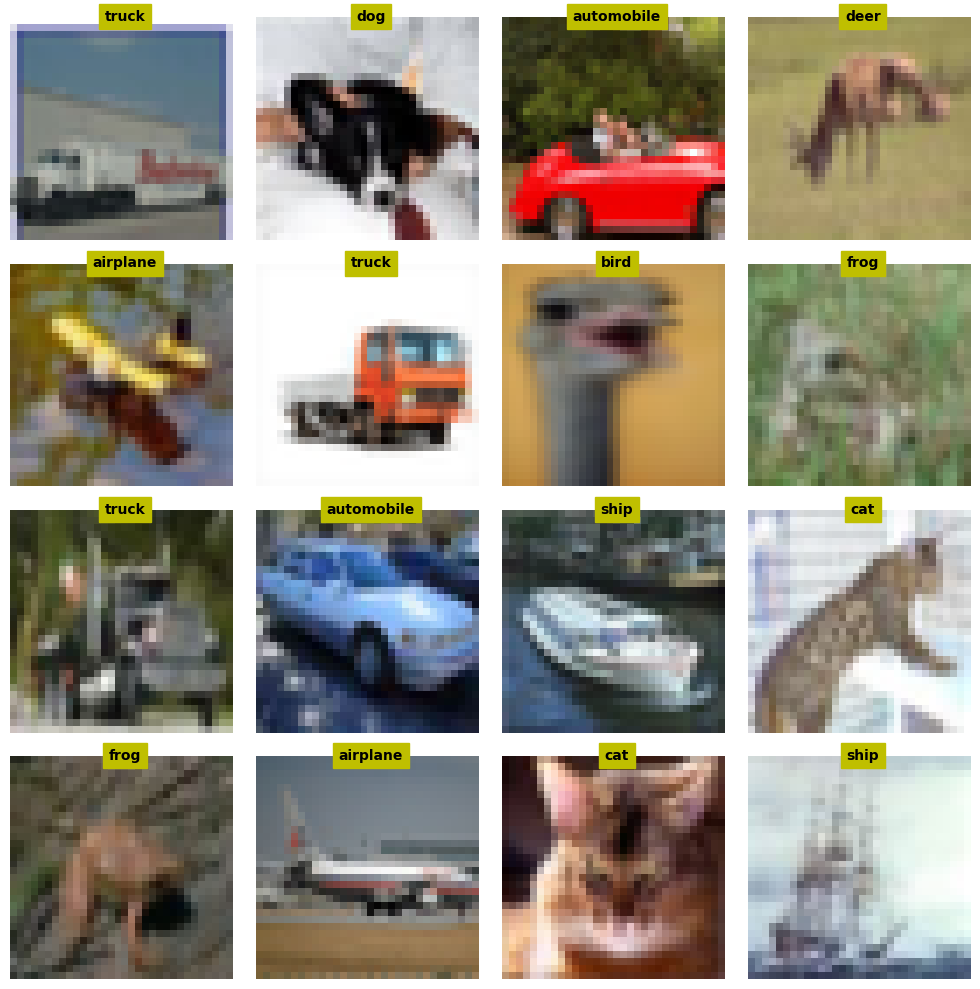

In [ ]:
# inspect a few random images
X,y = next(iter(train_loader))
fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
"""
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()

      # encoding layer
      self.enc = nn.Sequential(
          nn.Conv2d(3,16,4,stride=2,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.Conv2d(16,32,4,stride=2,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2)
          )

      # decoding layer
      self.dec = nn.Sequential(
          nn.ConvTranspose2d(4,6,3,2),
          nn.ReLU(),
          nn.ConvTranspose2d(6,1,3,2),
          )

    def forward(self,x):
      return self.dec( self.enc(x) )

  # create the model instance
  net = gausnet()

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [ ]:
# create a class for the model
def makeTheNet(printtoggle=False):

  class cifarnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(3,16,4,stride=2,padding=1)
      self.bnorm1 = nn.BatchNorm2d(16) # input the number of channels in this layer

      # second convolution layer
      self.conv2  = nn.Conv2d(16,32,4,stride=2,padding=1)
      self.bnorm2 = nn.BatchNorm2d(32) # input the number of channels in this layer

      # third convolution layer
      self.lat  = nn.Conv2d(32,64,4,stride=2,padding=1)                             #
      self.bnorm3 = nn.BatchNorm2d(64) # input the number of channels in this layer

      # fourth convolution layer
      self.conv4  = nn.ConvTranspose2d(64,32,4,stride=2,padding=1)
      #self.conv4  = nn.Conv2d(64,32,4,stride=2,padding=1)
      self.bnorm4 = nn.BatchNorm2d(32) # input the number of channels in this layer

      # fifth convolution layer
      #self.conv5  = nn.Conv2d(32,16,4,stride=2,padding=1)
      self.conv5  = nn.ConvTranspose2d(32,16,4,stride=2,padding=1)
      self.bnorm5 = nn.BatchNorm2d(16) # input the number of channels in this layer

      # sixth convolution layer
      self.conv6  = nn.ConvTranspose2d(16,3,4,stride=2,padding=1)
      #self.conv6  = nn.Conv2d(16,3,4,stride=2,padding=1)


    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = self.conv1(x)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = self.conv2(x)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = self.lat(x)
      x = F.leaky_relu(self.bnorm3(x))
      if self.print: print(f'Third CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = self.conv4(x)
      x = F.leaky_relu(self.bnorm4(x))
      if self.print: print(f'Third CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = self.conv5(x)
      x = F.leaky_relu(self.bnorm5(x))
      if self.print: print(f'Third CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = self.conv6(x)
      if self.print: print(f'Third CPR block: {list(x.shape)}')
      return x

  # create the model instance
  net = cifarnet(printtoggle)

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

 
torch.Size([32, 3, 32, 32])


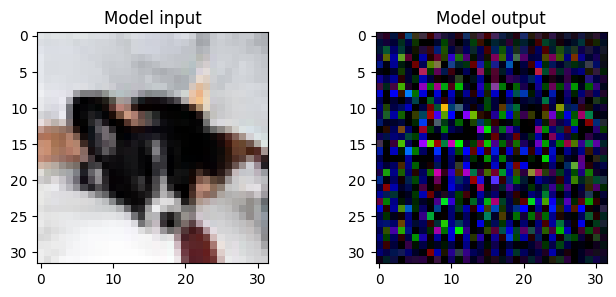

In [ ]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

yHat = net(X)

# check size of output
print(' ')
print(yHat.shape)

pic = X[1].numpy().transpose((1,2,0))
pic = pic/2 + .5

pic2=yHat[0].detach().numpy().transpose((1,2,0))
# let's see how they look
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].imshow(pic)
ax[0].set_title('Model input')
ax[1].imshow(pic2)
ax[1].set_title('Model output')

plt.show()

In [ ]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 15

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss  = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)

    ### test performance
    net.eval()
    batchLoss = []
    for X,y in dev_loader:
      # push data to GPU
      X = X.to(device)
      y = y.to(device)
      with torch.no_grad(): # deactivates autograd
        yHat = net(X)
        loss = lossfun(yHat,X)

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # get loss and error rate from the test batch
    devLoss[epochi] = np.mean(batchLoss)


  # end epochs

  # function output
  return trainLoss,devLoss,net

In [ ]:
trainLoss,devLoss,net = function2trainTheModel()

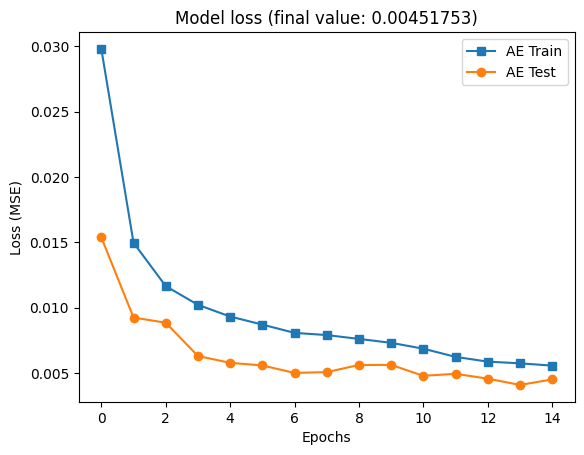

In [ ]:
plt.plot(trainLoss,'s-',label='AE Train')
plt.plot(devLoss,'o-',label='AE Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final value: %g)'%devLoss[-1])
plt.legend()

plt.show()

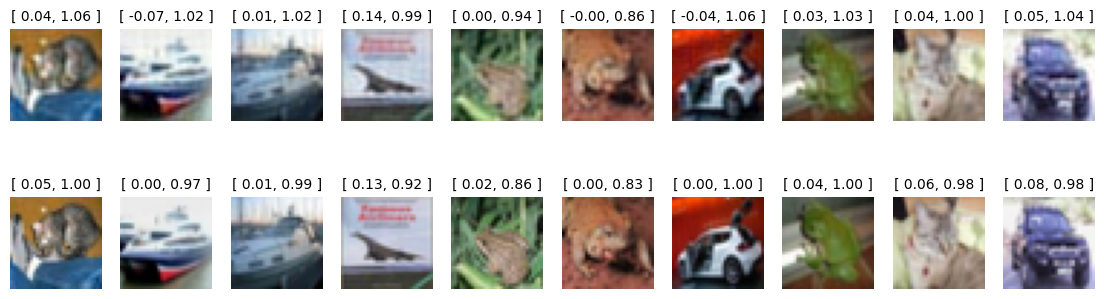

In [ ]:
## show some random examples

# get some data
X,y = next(iter(dev_loader))

# forward pass and loss
net.cpu()
net.eval() # switch to test mode
yHat = net(X)


fig,axs = plt.subplots(2,10,figsize=(14,4))

for i in range(10):
  pic = yHat[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[0,i].imshow(pic)
  axs[0,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[0,i].axis('off')

  pic = X[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[1,i].imshow(pic)
  axs[1,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[1,i].axis('off')


plt.show()